# Projet numérique 2021

In [1]:
# Chargement des dépendances

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib notebook

In [2]:
#Résultats issus du projet numérique 2020
#Discrétisation

A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta

#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

#Fonction C

def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

#Calcul de la matrice de distances

distmat=abs(np.subtract.outer(discretization,discretization))

#Calcul de la matrice de covariances et de ses blocs

Sigma=Covexp(distmat,a,sigma2)
SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]

#Calcul de l'espérance conditionnelle des composantes non observées

invSigma = np.linalg.inv(SigmaObs) 
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))

#Calcul de la matrice de covariance conditionnelle (complément de Schur de la matrice de covariance SigmaUnknown)

SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))

#Décomposition de Cholesky

Cholesky = np.linalg.cholesky(SigmaCond)

#Fonction calculant la longueur du fond marin

def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

## Valeurs positives

### Question 1

On reprend le code du précédent projet à partir de la partie simulation, où l'on implémente une boucle de rejet afin de ne garder que des valeurs négatives pour la profondeur.

<IPython.core.display.Javascript object>


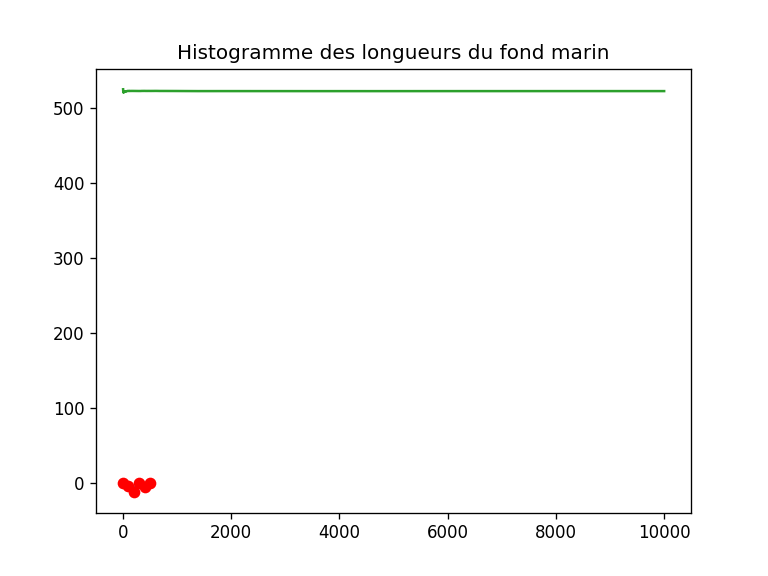

In [18]:
#Simulation de l'espérance conditionnelle des inconnues sachant les observations

x = np.random.normal(0,1,np.shape(unknown_indexes)[0])

simu = Ec + np.matmul(Cholesky,x)

for n in range(len(simu)):
    while simu[n]>0: #rejet et on resimule
        y = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        simu[n] = Ec[n] + np.matmul(Cholesky,y)[n]

#Simulation

allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth

allval3 = np.zeros(N)
allval3[unknown_indexes]=simu
allval3[observation_indexes]=depth
plt.plot(discretization,allval3)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

### Question 2

L'emploi de cet algorithme a-t-il un impact sur la valeur moyenne de la longueur de câble ? Sur l'histogramme des longueurs de câble ? Sur l'intervalle de confiance obtenu par la méthode des quantiles ? Sur la probabilité de dépassement du seuil de 525 m? Donner une estimation du taux de rejet de l'algorithme. Considérer 10000 simulations.

In [22]:
#On simule K fois la longueur du fond marin

K=100000

result = np.zeros(K)

for i in range(K):
    x=np.random.normal(0,1,np.shape(unknown_indexes)[0])
    allval3[unknown_indexes]=Ec + np.matmul(Cholesky,x)
    result[i]=length(allval3,Delta)

print("La longueur moyenne des simulations vaut", sum(result)/K)

La longueur moyenne des simulations vaut 522.4380347414774


In [19]:
#On calcule la longueur du fond marin de l'espérance conditionnelle des composantes non observées

print("La longueur de l'espérance conditionnelle vaut", length(allval1,Delta))

La longueur de l'espérance conditionnelle vaut 501.6468416918411


La longueur moyenne des simulations est pratiquement identique au cas sans la méthode de rejet.

<IPython.core.display.Javascript object>


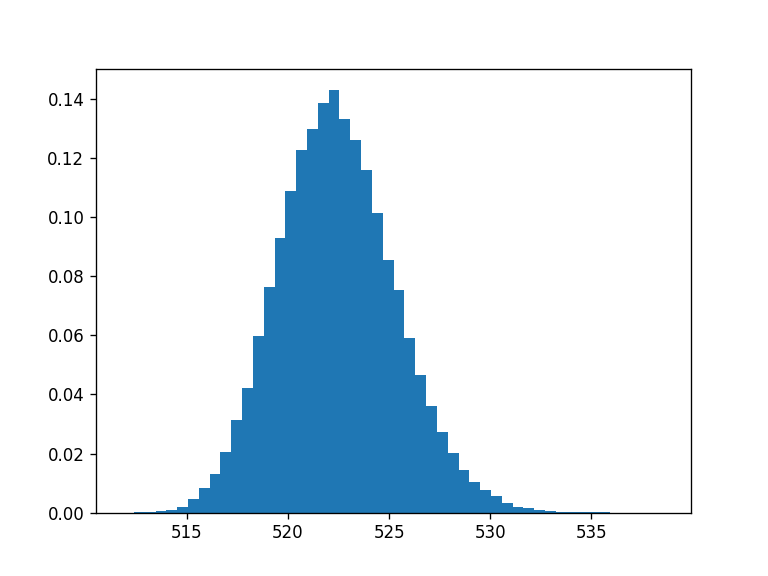

In [24]:
#Calcul de l'histogramme des longueurs du fond marin

indice_simu = 1+np.arange(K)

plt.hist(result,50,density=True)
plt.show()

L'histogramme garde la même forme qu'avant l'implémentation de la méthode de rejet, avec la même légère asymétrie.

In [26]:
#On reprend l'intervalle de confiance du projet précédent, 1ère méthode

Ln = sum(result)/K
sigman = np.std(result)
[Ln - sigman*1.96,Ln + sigman*1.96]

[516.7747181562692, 528.1013513266856]

Ici encore rien n'est changé.

In [28]:
#Pour la probabilité de dépasser 525m

print(np.mean(result>525))

0.18448


On retrouve encore un résultat très proche du précédent.

In [ ]:
#Estimation du taux de rejet de l'algorithme sur N itérations

N = 10000

tauxRejet = 0

x = np.random.normal(0,1,np.shape(unknown_indexes)[0])

for n in range(N):
    simu = Ec + np.matmul(Cholesky,x)

for n in range(len(simu)):
    while simu[n]>0: #rejet et on resimule
        y = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        simu[n] = Ec[n] + np.matmul(Cholesky,y)[n]